In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set environment variables
import os

os.environ["SCAL_TYPE"] = "complex"
os.environ["PRECISION"] = "single"
os.environ["MY_NUMBA_TARGET"] = "numba"
 
# Add cle_fun to PYTHON_PATH
import sys
sys.path.append("../../clonscal")

In [2]:
import src.scal as scal
a = np.zeros(int(1e9), dtype=scal.SCAL_TYPE)

Using single precision
Using C^1


In [3]:
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm

Using Numba


In [4]:
# Sim parameters
lamb = 1
sigma_abs = 4

start_angle = 0
stop_angle = 2*np.pi

num_ana = 256
angles_ana = np.linspace(start_angle, stop_angle, num_ana)
sigma_vals_ana = sigma_abs*(np.cos(angles_ana) + 1j*np.sin(angles_ana))

num_cl = 64
angles_cl = np.linspace(start_angle, stop_angle, num_cl)
sigma_vals_cl = sigma_abs*(np.cos(angles_cl) + 1j*np.sin(angles_cl))

In [5]:
# numerical integration
import numpy as np
from scipy.integrate import quad
from numba import jit

@jit
def integrand(x, order, sigma, lamb):
    """
    The integrand function exp(-sigma/2 * x^2 - lambda/4 * x^4).

    Parameters:
        x (float): The variable of integration.
        sigma (complex): Complex parameter for the quadratic term.
        lamb (float): Real parameter for the quartic term.

    Returns:
        complex: Value of the function at x.
    """
    return np.exp(-sigma / 2 * x**2 - lamb / 4 * x**4) * x**order

def compute_integral(order, sigma, lamb):
    """
    Computes the integral of the function over (-∞, ∞).

    Parameters:
        sigma (complex): Complex parameter for the quadratic term.
        lamb (float): Real parameter for the quartic term.

    Returns:
        complex: Value of the integral.
    """
    results = np.empty(sigma.shape, dtype = np.complex64)
    for idx, s in enumerate(sigma):
        real_part = quad(lambda x: np.real(integrand(x, order, s, lamb)), -np.inf, np.inf)[0]
        imag_part = quad(lambda x: np.imag(integrand(x, order, s, lamb)), -np.inf, np.inf)[0]
        results[idx] = real_part + 1j * imag_part
    return results

def n_moment_numeric(order, sigma, lamb):
    return compute_integral(order, sigma, lamb) / compute_integral(0, sigma, lamb)


In [6]:
def calculate_stats_complex(rolling_mean, rolling_sqr_mean, counter):
    """
    Calculate mean and SEM for complex numbers.
    
    Parameters:
    rolling_mean (np.array): Single-element array containing the rolling sum of complex values.
    rolling_sqr_mean (np.array): Single-element array containing the rolling sum of squared magnitudes of complex values.
    counter (np.array): Single-element array containing the number of values.
    
    Returns:
    tuple: (mean, sem_real, sem_imag), where:
        - mean is the complex mean,
        - sem_real is the SEM for the real part,
        - sem_imag is the SEM for the imaginary part.
    """
    if counter[0] == 0:
        raise ValueError("Counter cannot be zero to avoid division by zero.")
    
    # Extract real and imaginary parts
    rolling_mean_real = rolling_mean[0].real
    rolling_mean_imag = rolling_mean[0].imag
    
    # Mean calculation
    mean_real = rolling_mean_real / counter[0]
    mean_imag = rolling_mean_imag / counter[0]
    
    # Variance for real part
    rolling_sqr_mean_real = rolling_sqr_mean[0]
    variance = (rolling_sqr_mean_real / counter[0]) - mean_real**2 - mean_imag**2
    variance = max(variance, 0)
        
    # Standard error of the mean (SEM)
    sem = np.sqrt(variance / counter[0])
    
    # Return complex mean and SEM for real and imaginary parts
    mean = mean_real + 1j * mean_imag
    return mean, sem


In [7]:
# Running the simulation
from simulation.config import Config
from simulation.cl_simulation import ComplexLangevinSimulation
from src.obs_kernels import n_moment_kernel
from tqdm import tqdm

errors_dict = {'4_moment': [], '2_moment': [], '1_moment': []}
cl_estimate_dict = {'4_moment': [], '2_moment': [], '1_moment': []}
cl_hist_dict =  {'4_moment': [], '2_moment': [], '1_moment': []}
angles_dict = {'4_moment': [], '2_moment': [], '1_moment': []}


for angle, sigma in zip(angles_cl, (sigma_vals_cl)):
    config = Config(dt = 5e-2, trajs = int(2e4), dims = [1], mass_real = sigma, interaction = lamb, ada_step = True)
    sim = ComplexLangevinSimulation(config)
    
    sim.register_observable('1_moment', obs_kernel=n_moment_kernel, const_param={'order': 1}, langevin_history=False, thermal_time=1, auto_corr=0.5)
    sim.register_observable('2_moment', obs_kernel=n_moment_kernel, const_param={'order': 2}, langevin_history=False, thermal_time=1, auto_corr=0.5)
    sim.register_observable('4_moment', obs_kernel=n_moment_kernel, const_param={'order': 4}, langevin_history=False, thermal_time=1, auto_corr=0.5)

    for _ in tqdm(range(int(5e3))):
        sim.step()
        for name, tr in sim.trackers.items():
            tr.mark_equilibrated_trajs()
            tr.compute()
    sim.finish()

    for name, tr in sim.trackers.items():
        mean, sem = calculate_stats_complex(tr.rolling_mean, tr.rolling_sqr_mean, tr.counter)
        cl_estimate_dict[name].append(mean)
        errors_dict[name].append(sem)
        angles_dict[name].append(angle)


































































00%|█████████████████████████████████████| 5000/5000 [00:01<00:00, 2594.74it/s]

In [8]:
from analytic.analysis import Analysis
exact = Analysis()

from sympy import symbols, exp, sqrt, diff
from sympy.functions.special.bessel import besselk
sigma, lamda = symbols('sigma lamda')

xi = sigma**2 / (8 * lamda)
K_neg1_4 = besselk(-1/4, xi)
f_sigma = sqrt(4 * xi / sigma) * exp(xi) * K_neg1_4
exact.set_func('Z', f_sigma)

for k in range(10):
    exact.n_moment_phi4('Z', sigma, k)

def n_moment(analytics_obj, n):

    func_str = str(analytics_obj.funcs[f"{n}_moment_phi4"])
    function_code = f"""
def moment(sigma, lamda=1):
    from numpy import sqrt, exp
    from scipy.special import kv as besselk
    return {func_str}
"""
    local_namespace = {}
    exec(function_code, {}, local_namespace)
    return local_namespace[f"moment"]

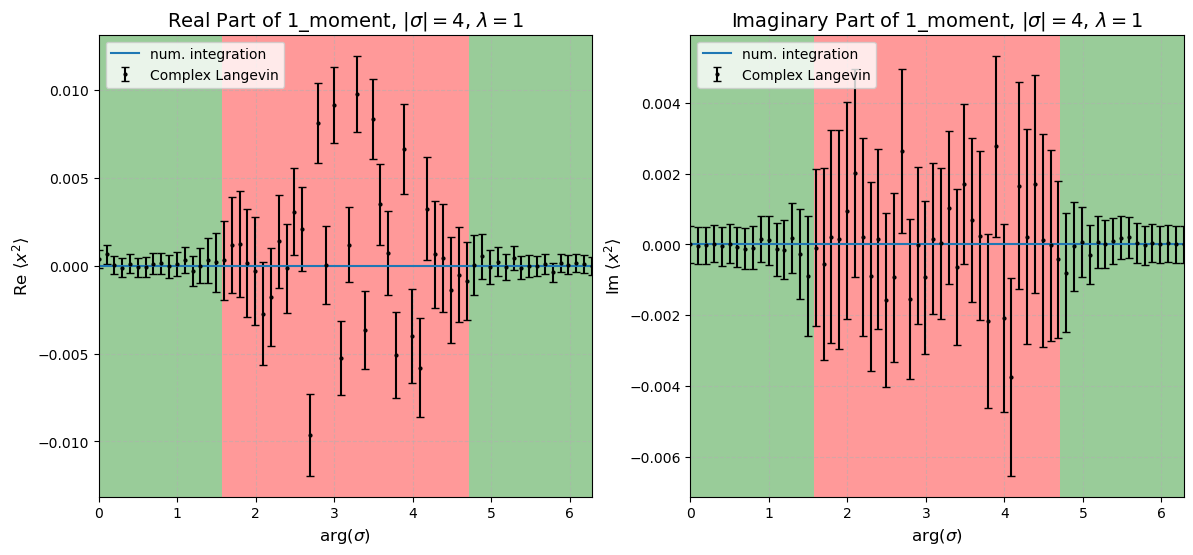

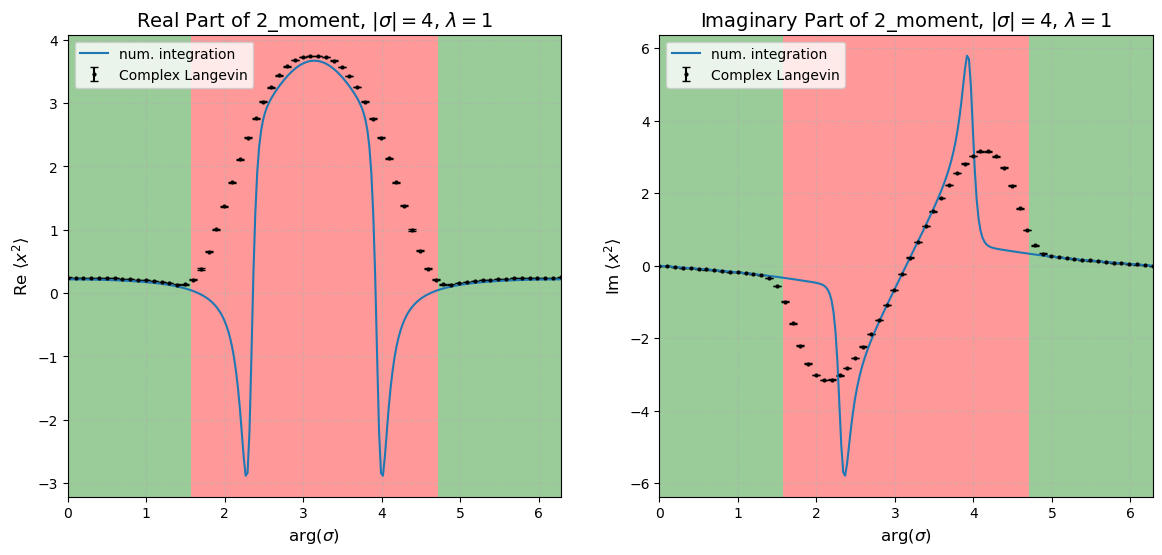

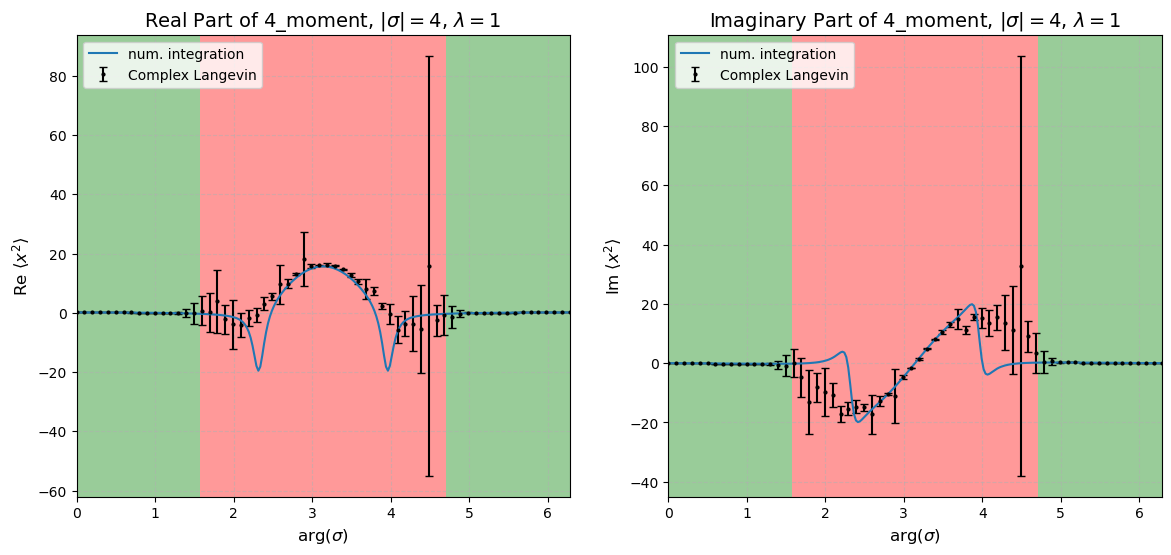

In [9]:

from scipy.signal import hilbert

# plt.style.use('science')
for name, tr in sim.trackers.items():
    order = tr.order

    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 
    
    # CL data
    cl_estimate = np.array(cl_estimate_dict[name])
    errors = np.array(errors_dict[name])
    axes[0].errorbar(angles_cl, cl_estimate.real, yerr=2*np.abs(errors), fmt='o',color='black', capsize=3 ,label='Complex Langevin', markersize=2)
    axes[1].errorbar(angles_cl, cl_estimate.imag, yerr=2*np.abs(errors), fmt='o',color='black', capsize=3 ,label='Complex Langevin', markersize=2)

    # numerical integration
    n_moment_num = n_moment_numeric(order, sigma_vals_ana, lamb)
    axes[0].plot(angles_ana, np.real(n_moment_num), label = "num. integration")
    axes[1].plot(angles_ana, np.imag(n_moment_num), label = "num. integration")
    
    # Analytical Function 
    #exact_func = n_moment(exact, order)
    #n_moment_ana = exact_func(sigma_vals_ana)
    
    # axes[0].plot(angles_ana, exact_func(sigma_vals_ana).real, color='red', label = "Analytic")
    # axes[1].plot(angles_ana, exact_func(sigma_vals_ana).imag, color='red', label = "Analytic")
    
    # # Titles
    axes[0].set_title(f'Real Part of {name}'+r', $|\sigma| = $'+f"{sigma_abs}"+r', $\lambda=$'+f"{lamb}", fontsize=14)
    axes[1].set_title(f'Imaginary Part of {name}'+r', $|\sigma| = $'+f"{sigma_abs}"+r', $\lambda=$'+f"{lamb}", fontsize=14)

    # Thimble Sectors
    for ax in axes: 
        ax.axvspan(0, np.pi/2, facecolor='green', alpha=0.4)
        ax.axvspan(np.pi/2, 3*np.pi/2, facecolor='red', alpha=0.4)
        ax.axvspan(3*np.pi/2, 2*np.pi, facecolor='green', alpha=0.4)
        
    # Formatting
    for ax in axes:
        ax.set_xlabel(r'arg($\sigma$)', fontsize=12)
        ax.grid(alpha=0.5, linestyle='--')
        ax.legend(fontsize=10, loc = 'upper left')
        ax.tick_params(axis='both', which='major', labelsize=10)
        ax.set_xlim(np.min(angles_ana), np.max(angles_ana))
    # plt.savefig(name)
    axes[0].set_ylabel(r'Re $\langle x^2 \rangle$', fontsize=12)
    axes[1].set_ylabel(r'Im $\langle x^2 \rangle$', fontsize=12)

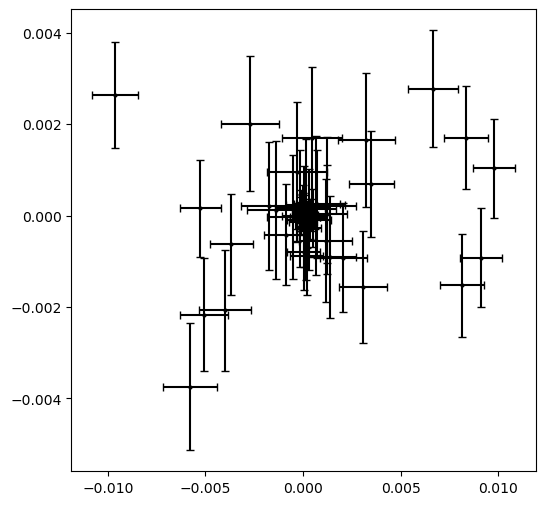

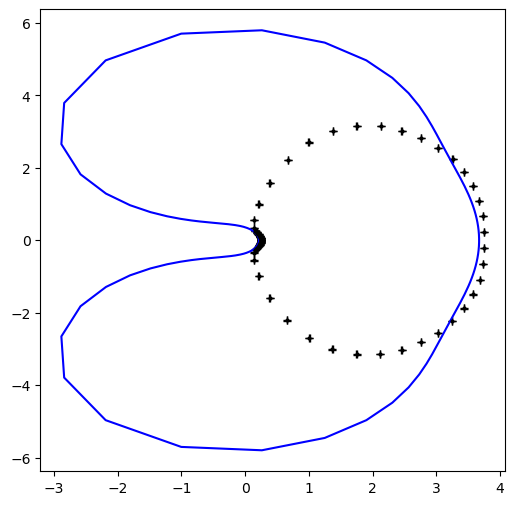

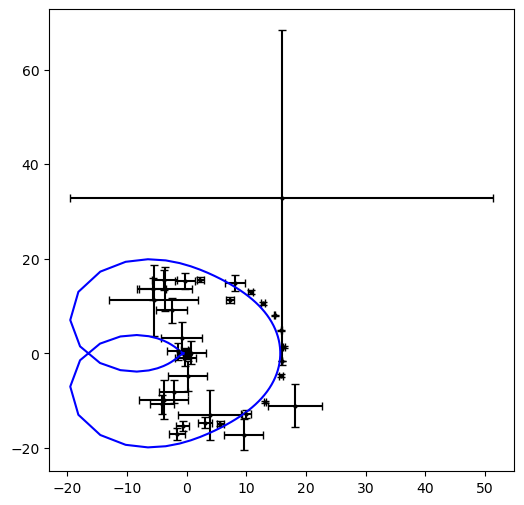

In [10]:
import matplotlib
for name, tr in sim.trackers.items():
    fig, axes = plt.subplots(1, figsize=(6, 6)) 

    order = tr.order
    
    # CL data
    cl_estimate = np.array(cl_estimate_dict[name])
    errors = np.array(errors_dict[name])
    axes.errorbar(cl_estimate.real, cl_estimate.imag, yerr=np.abs(errors), xerr = np.abs(errors),fmt='o',color='black', capsize=3 ,label='Complex Langevin', markersize=2)
        
    # numerical integration
    n_moment_num = n_moment_numeric(order, sigma_vals_ana, lamb)
    axes.plot(np.real(n_moment_num), np.imag(n_moment_num), label = "num. integration", color = "blue")
    rect1 = matplotlib.patches.Rectangle((-200,-100), 400, 200, color='yellow')
    plt.show()


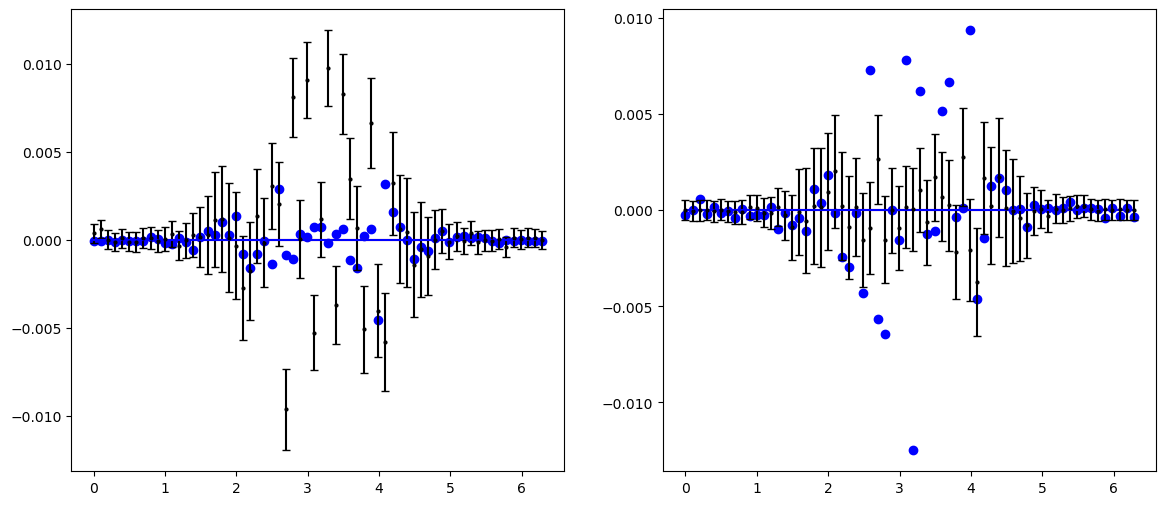

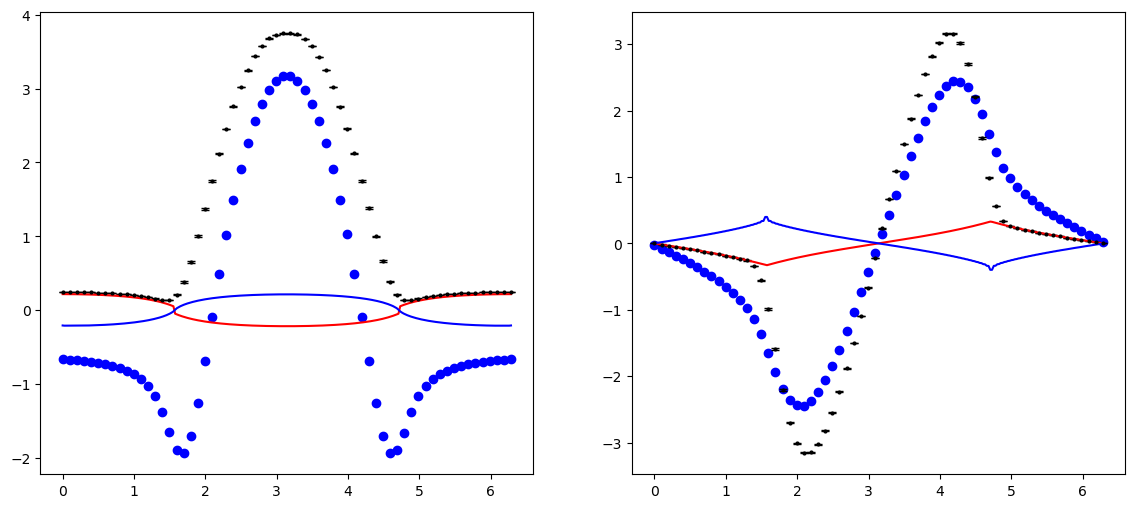

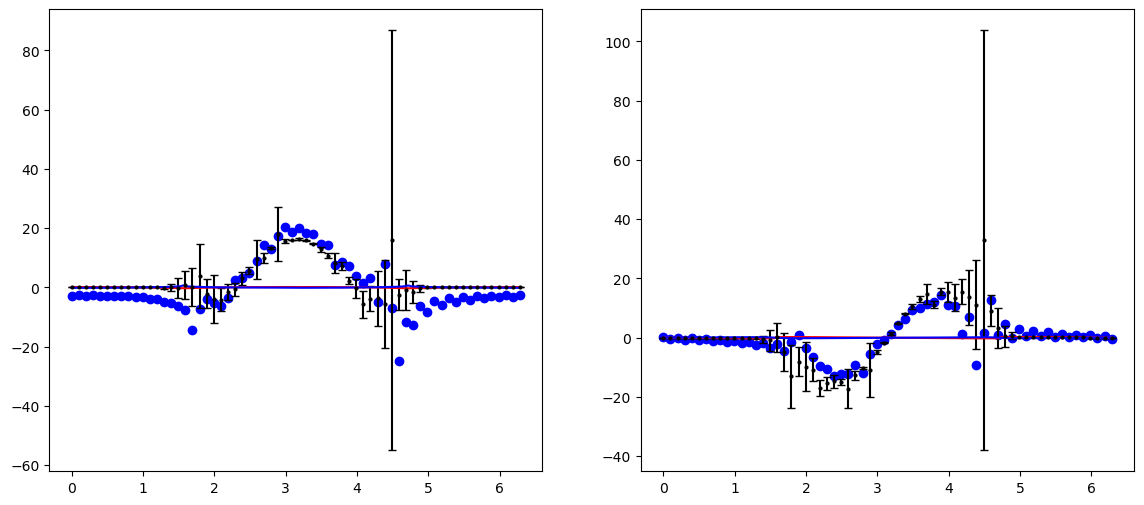

In [11]:
import scienceplots
from scipy.signal import hilbert

# plt.style.use('science')
for name, tr in sim.trackers.items():
    order = tr.order

    fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

    cl_estimate = np.array(cl_estimate_dict[name])
    errors = np.array(errors_dict[name])
    angles = np.array(angles_dict[name])

    kramers_imag = hilbert(cl_estimate.real).imag
    kramers_real = -hilbert(cl_estimate.imag).imag
    
    axes[0].errorbar(angles, cl_estimate.real, yerr=2*np.abs(errors), fmt='o',color='black', capsize=3 ,label='Complex Langevin', markersize=2)
    axes[0].scatter(angles, kramers_real,color='blue', label='Kramers Kronig')
    axes[1].errorbar(angles, cl_estimate.imag, yerr=2*np.abs(errors), fmt='o',color='black', capsize=3 ,label='Complex Langevin', markersize=2)
    axes[1].scatter(angles, kramers_imag,color='blue', label='Kramers Kronig')
    
    exact_func = n_moment(exact, order)
    n_moment_ana = exact_func(sigma_vals_ana)
    kramers_imag_ana = hilbert(n_moment_ana.real).imag
    kramers_real_ana = -hilbert(n_moment_ana.imag).imag

    axes[0].plot(angles_ana, exact_func(sigma_vals_ana).real, color='red', label = "Analytic")
    axes[0].plot(angles_ana, kramers_real_ana, color='blue', label = "Hilbert")
    axes[1].plot(angles_ana, exact_func(sigma_vals_ana).imag, color='red', label = "Analytic")
    axes[1].plot(angles_ana, kramers_imag_ana, color='blue', label = "Hilbert")

    # # Titles
    # axes[0].set_title(f'Real Part of {name}', fontsize=14)
    # axes[1].set_title(f'Imaginary Part of {name}', fontsize=14)

    # # Formatting
    # for ax in axes:
    #     ax.set_xlabel('Angle (radians)', fontsize=12)
    #     ax.grid(alpha=0.5, linestyle='--')
    #     ax.legend(fontsize=10, loc = 'upper left')
    #     ax.tick_params(axis='both', which='major', labelsize=10)
    # # plt.savefig(name)
    # axes[0].set_ylabel(r'Re $\langle x^2 \rangle$', fontsize=12)
    # axes[1].set_ylabel(r'Im $\langle x^2 \rangle$', fontsize=12)

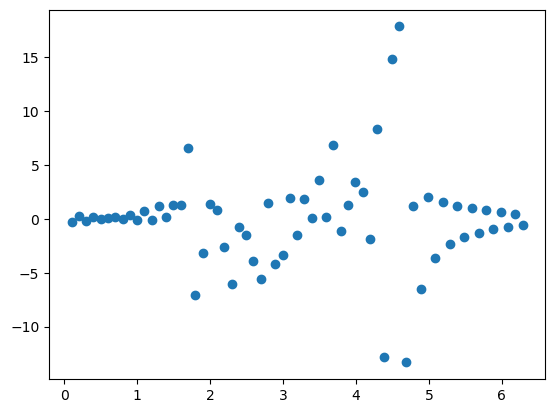

In [12]:
kramers_imag = hilbert(cl_estimate.real).imag
kramers_real = -hilbert(cl_estimate.imag).imag

plt.scatter(angles[1:], -np.diff(kramers_real))

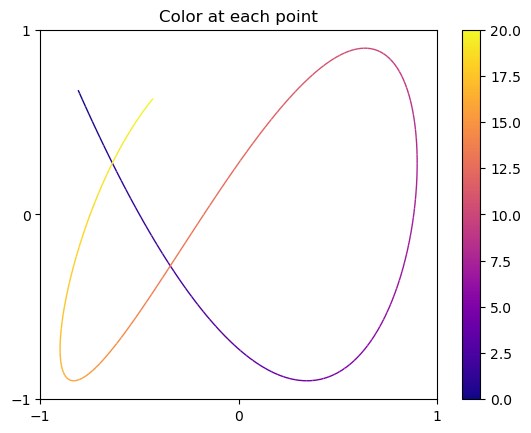

In [13]:
from matplotlib.collections import LineCollection

def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


# -------------- Create and show plot --------------
# Some arbitrary function that gives x, y, and color values
t = np.linspace(-7.4, -0.5, 200)
x = 0.9 * np.sin(t)
y = 0.9 * np.cos(1.6 * t)
color = np.linspace(0, 20, t.size)

# Create a figure and plot the line on it
fig1, ax1 = plt.subplots()
lines = colored_line(x, y, color, ax1, linewidth=1, cmap="plasma")
fig1.colorbar(lines)  # add a color legend

# Set the axis limits and tick positions
ax1.set_xlim(-1, 1)
ax1.set_ylim(-1, 1)
ax1.set_xticks((-1, 0, 1))
ax1.set_yticks((-1, 0, 1))
ax1.set_title("Color at each point")

plt.show()

In [14]:
for name, tr in sim.trackers.items():

    cl_estimate = np.array(cl_estimate_dict[name])

    
    # plt.scatter(cl_estimate.real, cl_estimate.imag, color = 'black')
    plt.scatter(exact_dict[f"{name}_phi4"].real, exact_dict[f"{name}_phi4"].imag, color = 'red', s=2)

    kramers_imag = hilbert(exact_dict[f"{name}_phi4"].imag).imag
    kramers_real = -hilbert(exact_dict[f"{name}_phi4"].real).imag

    plt.plot(-kramers_real, kramers_imag, color = 'blue')
    plt.show()

NameError: name 'exact_dict' is not defined

In [ ]:
exact

In [ ]:
from numpy import sqrt, exp
from scipy.special import kv as besselk

def sec_mom(sigma, lamda):
    return sqrt(2)*(-sqrt(2)*sqrt(sigma/lamda)*exp(sigma**2/(8*lamda))*besselk(-0.25, sigma**2/(8*lamda))/(2*sigma)- sqrt(2)*sigma*sqrt(sigma/lamda)*(-besselk(-1.25, sigma**2/(8*lamda))/2 - besselk(0.75, sigma**2/(8*lamda))/2)*exp(sigma**2/(8*lamda))/(4*lamda) - sqrt(2)*sigma*sqrt(sigma/lamda)*exp(sigma**2/(8*lamda))*besselk(-0.25, sigma**2/(8*lamda))/(4*lamda))*exp(-sigma**2/(8*lamda))/(sqrt(sigma/lamda)*besselk(-0.25, sigma**2/(8*lamda)))

exact = sec_mom(sigma_vals_ana, 2) 
exact_real = exact.real
exact_imag = exact.imag

plt.scatter(exact_real, exact_imag, color = 'red', s=2)

kramers_imag = hilbert(exact_real).imag
kramers_real = -hilbert(exact_imag).imag

plt.plot(-kramers_real, kramers_imag, color = 'blue')
plt.show()
